## Data Analysis Interview Challenge
### Part 1 ‑ Exploratory data analysis

Task: 
Aggregate these login counts based on 15 minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

This log data contains (simulated) timestamps of user logins to a platform in a particular geographic location.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt
import json
%matplotlib inline
import pickle
# data viz imports
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
import seaborn as sns
# time-series imports
from datetime import datetime
# imports for xgboost
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, cv, plot_importance

from sklearn.model_selection import RandomizedSearchCV

import warnings # For handling error messages. 
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [2]:
# load data as a data frame
logins = pd.read_json("logins.json")

In [3]:
logins.head(10)  # YY-MM-DD HH:MM:SS

login_time
0 1970-01-01 20:13:18
1 1970-01-01 20:16:10
2 1970-01-01 20:16:37
3 1970-01-01 20:16:36
4 1970-01-01 20:26:21
5 1970-01-01 20:21:41
6 1970-01-01 20:12:16
7 1970-01-01 20:35:47
8 1970-01-01 20:35:38
9 1970-01-01 20:47:52

In [4]:
logins.tail(10)

login_time
93132 1970-04-13 18:36:53
93133 1970-04-13 18:40:31
93134 1970-04-13 18:46:06
93135 1970-04-13 18:40:40
93136 1970-04-13 18:48:52
93137 1970-04-13 18:50:19
93138 1970-04-13 18:43:56
93139 1970-04-13 18:54:02
93140 1970-04-13 18:57:38
93141 1970-04-13 18:54:23

##### The data spans over a period of 4 months, starting January 1st 1970 till April 13th, 1970. 

In [5]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


###### There are 93142 non-null loginds with type datetime64 

In [6]:
logins.isnull().sum()

login_time    0
dtype: int64

###### No missing values

In [7]:
# Resetting the dates as index 

In [8]:
logins= logins.set_index('login_time')

In [9]:
logins.head()

Empty DataFrame
Columns: []
Index: [1970-01-01 20:13:18, 1970-01-01 20:16:10, 1970-01-01 20:16:37, 1970-01-01 20:16:36, 1970-01-01 20:26:21]

In [10]:
# Crearting a coulmn to count the number of logins, it will be 1 for each data point 

logins['login_count'] = 1

In [11]:
logins.head()

login_count
login_time                      
1970-01-01 20:13:18            1
1970-01-01 20:16:10            1
1970-01-01 20:16:37            1
1970-01-01 20:16:36            1
1970-01-01 20:26:21            1

In [12]:
# resample the index, so that time is represented in 15 min chunks
logins_delta15 = logins.resample('15Min').sum()

In [13]:
logins_delta15.head()

login_count
login_time                      
1970-01-01 20:00:00            2
1970-01-01 20:15:00            6
1970-01-01 20:30:00            9
1970-01-01 20:45:00            7
1970-01-01 21:00:00            1

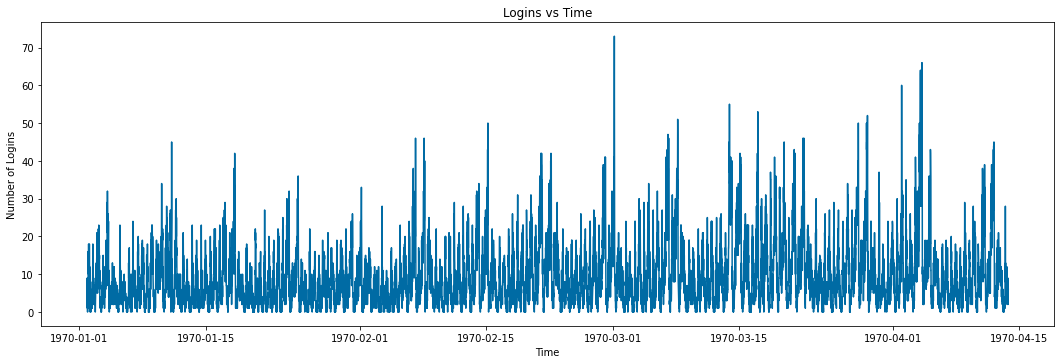

In [14]:
fig, ax = plt.subplots(figsize = (15,5))
plt.xlabel('Time')
plt.ylabel('Number of Logins')
plt.tight_layout()
plt.title('Logins vs Time')
# puts the data in the figure
plt.plot(logins_delta15.index, logins_delta15.login_count);

###### There is a cyclic pattern in the data but it's hard to see at this scale. We need to look at larger scales.  

In [15]:
# aggregating data based on daily, business day (M-F), fridays, saturdays, and sundays
logins_daily = logins.resample('D').sum()
logins_biz_day = logins.resample('B').sum()
fridays = logins.resample('W-FRI').sum()
saturdays = logins.resample('W-SAT').sum()
sundays = logins.resample('W-SUN').sum()

C:\Users\msale\AppData\Local\Temp/ipykernel_27492/1161273615.py:4: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.title('Logins over Time for different cases', Fontsize = 22)


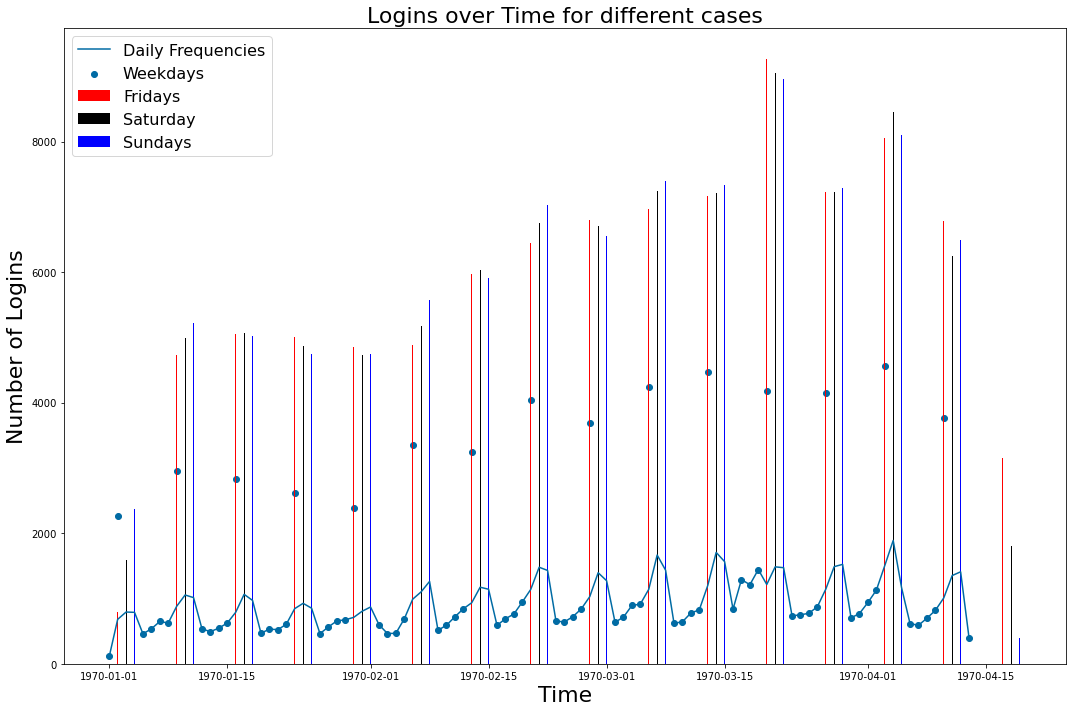

In [16]:
fig, ax = plt.subplots(figsize = (15,10))
plt.xlabel('Time', fontsize = 22)
plt.ylabel('Number of Logins', fontsize = 22)
plt.title('Logins over Time for different cases', Fontsize = 22)

plt.bar(fridays.index, fridays.login_count, align= 'center', width = 0.1, label = "Fridays", color = 'r')
plt.bar(saturdays.index, saturdays.login_count, label = 'Saturday', align = 'center', width = 0.1, color = 'Black')
plt.bar(sundays.index, sundays.login_count, label = "Sundays", align= 'center', width = 0.1, color = 'b')
plt.plot(logins_daily.index, logins_daily.login_count, label = 'Daily Frequencies')
plt.scatter(logins_biz_day.index, logins_biz_day.login_count, label='Weekdays')

plt.legend(loc='upper left', fontsize = 16)
plt.tight_layout()

#### The figure above shows that Friday has the most logins # and the weekends are busier than the weekdays. 

###### Looking at the hourly trends by day of week

In [17]:
# resample index hourly
daily_logins = logins.resample('H').sum()

# create a column that identify the day of week; Monday=0, Sunday=0
day_of_week = list(daily_logins.index.dayofweek)
daily_logins['day_of_week'] = day_of_week

# add a column with just the hour (omiting the date)
daily_logins['hour'] = [time.hour for time in daily_logins.index]

In [18]:
# create dataframe with the average number of logins for each hour of each day
avg_hourly_logins = pd.pivot_table(daily_logins, values = 'login_count', index = 'hour', columns = 'day_of_week', aggfunc=np.mean).rename(columns= {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'})
# stack
avg_hourly_logins = avg_hourly_logins.stack(level=['day_of_week'])
# name the stack
avg_hourly_logins.name = 'avg_num_logins'
avg_hourly_logins_df = avg_hourly_logins.reset_index()

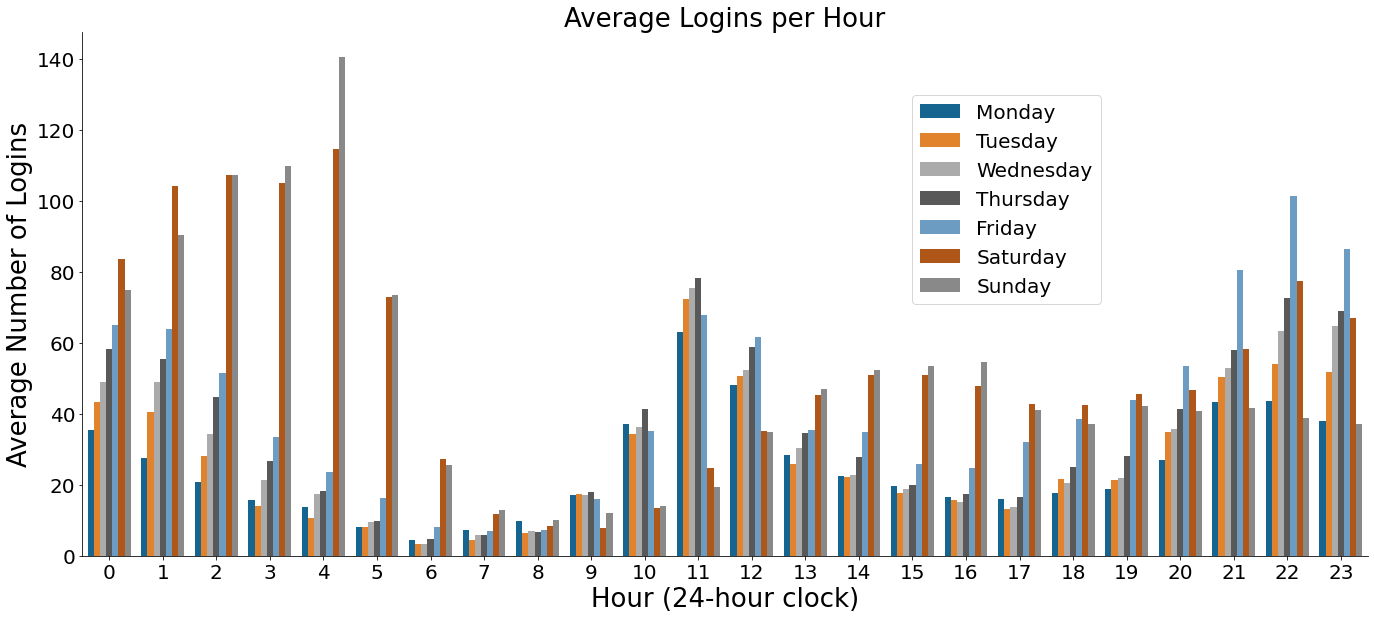

In [19]:
# plot average hourly use
sns.catplot(x='hour', y='avg_num_logins', data=avg_hourly_logins_df, kind = 'bar', 
            hue='day_of_week',height=8, aspect=11.7/5, legend=False)
ax = plt.gca()
ax.set_title('Average Logins per Hour', fontsize = 26)
ax.set_xlabel('Hour (24-hour clock)', fontsize = 26)
ax.set_ylabel('Average Number of Logins', fontsize = 26)
ax.tick_params(labelsize=20,labelcolor="black")
ax.legend(bbox_to_anchor=(0.7,0.7,0.1, 0.2),fontsize=20);

###### The figure above shows the most logins occurs during the early hours (1 AM - 5 AM) on Saturdays and Sundays. During the weekdays there are spikes in logins during lunch hours (11 am to noon), and in the evening (9 PM - 11 PM), with Fridays evenings (21-23) shows the most logins. 

### Part 2 ‑ Experiment and metrics design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two-way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

  1) What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both           cities, and why would you choose this metric?
  2) Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to           the key measure of success. Please provide details on:
                                   how you will implement the experiment?
                                   what statistical test(s) you will conduct to verify the significance of the observation?
                                   how you would interpret the results and provide recommendations to the city operations team                                      along with any caveats.

To choose a key measure of success, I am assuming there is system in place to keep track of the number of cars that use the bridge in both directions. To get reimbursed, partner drivers would also need a record of crossing. We also need to make sure there is historical record of data on bridge use before implementing the change.   


The key metric I would choose is change in weekday activity (two cities having opposite trends during weekdays). Of particualr interest, we want to see if during the daytime hours (6 am - 6 pm) on weekdays, is there an increase of cars entering the bridge from Gotham (where driver partners are active at night) AND during the nighttime hours (7 pm - 5 am) on weekdays is there an increase of cars entering the bridge from Metropolis (where driver partners are active at day). I choose these metrics based on the above assumptions, and they can be easily measured. 

In order to answer the above questions I would use **two hypothesis tests**:

1) 
H0_1: There is no difference between the mean number of cars entering the bridge from Gotham during weekdays between the hours of 6 am and 6 pm, three weeks before reimbursements went into effect and the mean number of cars three weeks after reimbursements were offered.

H1_1: There is an INCREASE in the mean number of cars entering the bridge from Gotham during weekdays between 6 am and 6 pm, three weeks before reimbursements went into effect and the mean number of cars three weeks after reimbursements were offered.

2) 
H0_2: There is no difference between the mean number of cars entering the bridge from Metropolis during weekdays between 7 pm and 5 am, three weeks before reimbursements went into effect and the mean number of cars three weeks after reimbursements were offered.

H1_2: There is an INCREASE in the mean number of cars entering the bridge from Metropolis during weekdays between 7 pm and 5 am, three weeks before reimbursements went into effect and the mean number of cars three weeks after reimbursements were offered.

I would use a **one-tailed t-test** to determine the p-value of each hypothesis.

If the p-value is less than 0.05 for BOTH tests I would reject the null hypotheses and recommend the reimbursement program continue, with the condition that the study should be repeated in a near future with more data.

If the p-value is greater than 0.05 for BOTH tests I would fail to reject the null hypotheses and recommend that a different program be developed to increase partner driving between the two cities.

If the p-value is mixed, so only one hypothesis has a p-value less than 0.05 I would recommend that the analysis is inconclusive and that further investigation is needed.

### Part 3 ‑ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

The data is in the attached file ultimate_data_challenge.json.

        Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few 
        sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
        
        Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the 
        system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How   
        valid is your model? Include any key indicators of model performance.
        
        Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider 
        retention (again, a few sentences will suffice).


**Assumptions Made**
The date of when the data was pulled is not given, so we cannot tell if they had a trip in the 30 days before that date, nor is a user ID given. Thus, I will assume:

    That the most recent trip taken was the day the data was pulled
    Each row represents a summary of a unique user

In [58]:
# load data
with open('ultimate_data_challenge.json') as f:
    data = json.load(f)

# put data info pandas dataframe
user_data = pd.DataFrame(data)

In [59]:
user_data.head()

city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
0  King's Landing                       4  2014-01-25                   4.7   
1         Astapor                       0  2014-01-29                   5.0   
2         Astapor                       3  2014-01-06                   4.3   
3  King's Landing                       9  2014-01-10                   4.6   
4      Winterfell                      14  2014-01-27                   4.4   

   avg_surge last_trip_date    phone  surge_pct  ultimate_black_user  \
0       1.10     2014-06-17   iPhone       15.4                 True   
1       1.00     2014-05-05  Android        0.0                False   
2       1.00     2014-01-07   iPhone        0.0                False   
3       1.14     2014-06-29   iPhone       20.0                 True   
4       1.19     2014-03-15  Android       11.8                False   

   weekday_pct  avg_dist  avg_rating_by_driver  
0         46.2      3.67                   5.0  
1         50.0      8.26                   5.0  
2        100.0      0.77                   5.0  
3         80.0      2.36                   4.9  
4         82.4      3.13                   4.9

In [60]:
user_data.info() # dates are objects 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [65]:
# convert dates to datetime objects
user_data['signup_date'] = pd.to_datetime(user_data['signup_date'])
user_data['last_trip_date'] = pd.to_datetime(user_data['last_trip_date'])

In [66]:
# find the date the data was pulled
pull_date = user_data.last_trip_date.max()
pull_date  # seems data was pulled on July 1st 

Timestamp('2014-07-01 00:00:00')

In [67]:
# determine 30 days previous to the pull day   
# we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days
cut_off_day = pull_date - pd.Timedelta('30 days')

In [69]:
# add active status to dataframe  0= inactive, 1 = active
user_data['active_status'] = (user_data.last_trip_date > cut_off_day).astype('int')


In [70]:
user_data["ultimate_black_user"] = user_data["ultimate_black_user"].astype(int)

In [71]:
user_data.head()

city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
0  King's Landing                       4  2014-01-25                   4.7   
1         Astapor                       0  2014-01-29                   5.0   
2         Astapor                       3  2014-01-06                   4.3   
3  King's Landing                       9  2014-01-10                   4.6   
4      Winterfell                      14  2014-01-27                   4.4   

   avg_surge last_trip_date    phone  surge_pct  ultimate_black_user  \
0       1.10     2014-06-17   iPhone       15.4                    1   
1       1.00     2014-05-05  Android        0.0                    0   
2       1.00     2014-01-07   iPhone        0.0                    0   
3       1.14     2014-06-29   iPhone       20.0                    1   
4       1.19     2014-03-15  Android       11.8                    0   

   weekday_pct  avg_dist  avg_rating_by_driver  active_status  
0         46.2      3.67                   5.0              1  
1         50.0      8.26                   5.0              0  
2        100.0      0.77                   5.0              0  
3         80.0      2.36                   4.9              1  
4         82.4      3.13                   4.9              0

In [72]:
user_data.isnull().sum() 

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
active_status                0
dtype: int64

###### There are missing values, espicially for avg_rating_of_driver (over 8000 counts)

In [73]:
user_data.dropna(inplace=True)   # dropping NaN values 

In [74]:
uniqueCities = user_data['city'].unique()  # checking the variaty of cities 
uniqueCities

array(["King's Landing", 'Astapor', 'Winterfell'], dtype=object)

In [75]:
 uniquePhones = user_data['phone'].unique() 
uniquePhones

array(['iPhone', 'Android'], dtype=object)

In [76]:
# add dummies to categorical data city and phone 
user_data = pd.get_dummies(user_data, columns = ['city', 'phone'])

In [80]:
user_data.head()  # all features are numerical 

trips_in_first_30_days signup_date  avg_rating_of_driver  avg_surge  \
0                       4  2014-01-25                   4.7       1.10   
1                       0  2014-01-29                   5.0       1.00   
2                       3  2014-01-06                   4.3       1.00   
3                       9  2014-01-10                   4.6       1.14   
4                      14  2014-01-27                   4.4       1.19   

  last_trip_date  surge_pct  ultimate_black_user  weekday_pct  avg_dist  \
0     2014-06-17       15.4                    1         46.2      3.67   
1     2014-05-05        0.0                    0         50.0      8.26   
2     2014-01-07        0.0                    0        100.0      0.77   
3     2014-06-29       20.0                    1         80.0      2.36   
4     2014-03-15       11.8                    0         82.4      3.13   

   avg_rating_by_driver  active_status  city_Astapor  city_King's Landing  \
0                   5.0              1             0                    1   
1                   5.0              0             1                    0   
2                   5.0              0             1                    0   
3                   4.9              1             0                    1   
4                   4.9              0             0                    0   

   city_Winterfell  phone_Android  phone_iPhone  
0                0              0             1  
1                0              1             0  
2                0              0             1  
3                0              0             1  
4                1              1             0

In [81]:
#separate the active and inactive users
active_user = user_data[user_data.active_status == 1]
inactive_user = user_data[user_data.active_status == 0]

In [82]:
# fraction of the observed users that were retained
fraction = round((len(active_user.active_status)/len(user_data.active_status)) * 100, 2)
print('{} percent of users were retained.'.format(fraction))

40.07 percent of users were retained.


In [83]:
user_data.columns

Index(['trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'surge_pct', 'ultimate_black_user',
       'weekday_pct', 'avg_dist', 'avg_rating_by_driver', 'active_status',
       'city_Astapor', 'city_King's Landing', 'city_Winterfell',
       'phone_Android', 'phone_iPhone'],
      dtype='object')

In [84]:
# calculating mean and standard deviation for each feature for active and inactive users
feature_columns = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
 'surge_pct', 'ultimate_black_user', 'weekday_pct', 'city_Astapor',
 "city_King's Landing", 'city_Winterfell', 'phone_Android','phone_iPhone']
stats_dict = {}
for col in feature_columns:
    stats_dict[col] = [active_user[col].mean(), active_user[col].std(),
                       inactive_user[col].mean(),inactive_user[col].std()]

In [85]:
# create a dataframe of the statistics
stats_df = pd.DataFrame.from_dict(stats_dict, orient='index').rename(columns = {0:'active_mean', 1:'active_std', 2:'inactive_mean', 3:'inactive_std'})

In [86]:
stats_df

active_mean  active_std  inactive_mean  inactive_std
avg_dist                 4.914539    4.135179       5.824816      5.692917
avg_rating_by_driver     4.759387    0.293452       4.787853      0.463974
avg_rating_of_driver     4.593497    0.538174       4.607219      0.663079
avg_surge                1.072629    0.142464       1.074619      0.228783
surge_pct                9.109694   14.045947       8.757628     20.693270
ultimate_black_user      0.516257    0.499751       0.295728      0.456379
weekday_pct             62.385814   27.251023      60.498675     39.044695
city_Astapor             0.219412    0.413861       0.397190      0.489326
city_King's Landing      0.342425    0.474535       0.124331      0.329965
city_Winterfell          0.438162    0.496176       0.478480      0.499547
phone_Android            0.158538    0.365256       0.380883      0.485614
phone_iPhone             0.841462    0.365256       0.619117      0.485614

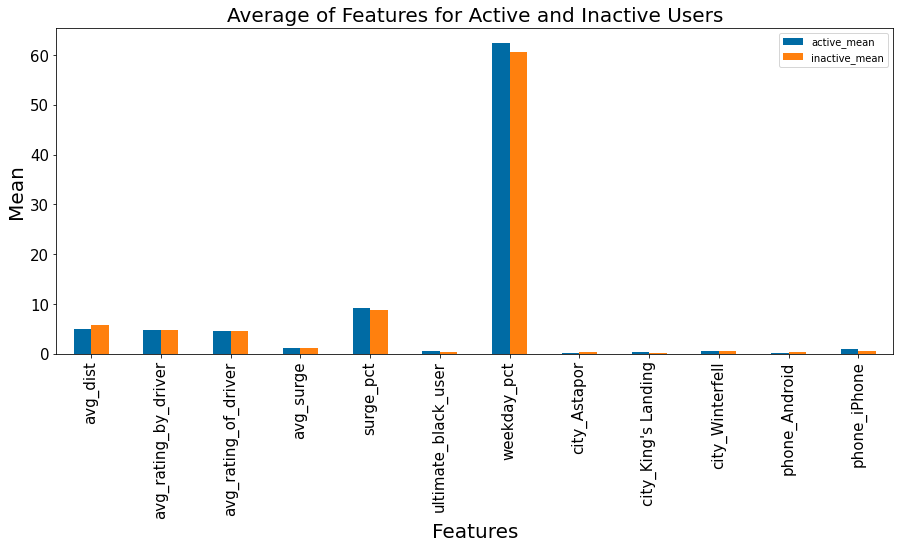

In [87]:
# visualize the statistics
stats_df[['active_mean', 'inactive_mean']].plot(kind = 'bar', yerr=stats_df[['active_std','inactive_std']], figsize = (15,6), fontsize = 15)
plt.xlabel('Features',fontsize = 20)
plt.ylabel('Mean', fontsize = 20)
plt.title('Average of Features for Active and Inactive Users', fontsize = 20);

##### The figure above shows there is not a significant difference between the average of the features for active and inactive users.

##### Model using XGBClassifier

In [88]:
# define features and target variables
X = user_data[feature_columns]  # we are not using all the features here 
y = user_data['active_status']

In [89]:
X.head()

avg_dist  avg_rating_by_driver  avg_rating_of_driver  avg_surge  surge_pct  \
0      3.67                   5.0                   4.7       1.10       15.4   
1      8.26                   5.0                   5.0       1.00        0.0   
2      0.77                   5.0                   4.3       1.00        0.0   
3      2.36                   4.9                   4.6       1.14       20.0   
4      3.13                   4.9                   4.4       1.19       11.8   

   ultimate_black_user  weekday_pct  city_Astapor  city_King's Landing  \
0                    1         46.2             0                    1   
1                    0         50.0             1                    0   
2                    0        100.0             1                    0   
3                    1         80.0             0                    1   
4                    0         82.4             0                    0   

   city_Winterfell  phone_Android  phone_iPhone  
0                0              0             1  
1                0              1             0  
2                0              0             1  
3                0              0             1  
4                1              1             0

In [90]:
y.head()

0    1
1    0
2    0
3    1
4    0
Name: active_status, dtype: int32

In [91]:
# split training and test data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

split data into training and test sets
optimize hyperparameters using the training set and random crossfold validation
validate using an unoptimized model AND the test set
train optimized model using the entire feature set

In [92]:
# instantiate base classifier 
xg_clf = XGBClassifier(verbosity =0, objective = 'binary:logistic',random_state = 42)

In [93]:
# train base classifier
xg_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [94]:
# predict the labels on training set 
y_pred = xg_clf.predict(X_train)
# score model
score = accuracy_score(y_train, y_pred)
# print accuracy
print("The accuracy of the base classifier on training set is {}.".format(round(score,4)))

The accuracy of the base classifier on training set is 0.8355.


In [95]:
# predict the labels on test set 
y_test_pred = xg_clf.predict(X_test)

# score model
test_score = accuracy_score(y_test, y_test_pred)
# print accuracy
print("The accuracy of the base classifier for the test set is {}.".format(round(test_score,4)))

The accuracy of the base classifier for the test set is 0.772.


###### Optimizing the model 

In [96]:
parameters = {
    'max_delta_step':[0,0.05],
    'scale_pos_weight':[0.95, 0.8],
    'subsample':[0.5,0.75,1.0],
    'learning_rate': [0.2, 0.1, 0.05],
    'min_child_weight':[0,1,2],
    'gamma':[1, 2, 3],
    'max_depth': [6,8,10]
    }

In [97]:
from sklearn.model_selection import RepeatedKFold

In [98]:
# Random GridSearch 
cv = RepeatedKFold(n_splits= 3, n_repeats=1, random_state=42)
grid_search = RandomizedSearchCV(estimator = xg_clf, param_distributions = parameters, n_iter = 100, cv = cv, verbose=2, random_state=42, n_jobs = -1)

In [99]:
grid_search.fit(X_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=RepeatedKFold(n_repeats=1, n_splits=3, random_state=42),
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           callbacks=None, colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=0, gpu_id=-1,
                                           grow_policy='depthwise',
                                           importance_type=None,
                                           interaction_c...
                                           n_estimators=100, n_jobs=0,
                                           num_parallel_tree=1,
                                           predictor='auto', random_state=42,
           

In [100]:
# Print best parameters and results
print(grid_search.best_params_)
print(grid_search.best_score_)

{'subsample': 0.75, 'scale_pos_weight': 0.95, 'min_child_weight': 1, 'max_depth': 8, 'max_delta_step': 0, 'learning_rate': 0.05, 'gamma': 3}
0.7793596965108996


In [101]:
# optimized parameters
optimized_parameters = {'objective':'binary:logistic',
                        'verbosity': 0,
                        'random_state': 42,
                        'subsample': 0.75, 
                        'scale_pos_weight': 0.95, 
                        'min_child_weight': 1, 
                        'max_depth': 8, 
                        'max_delta_step': 0, 
                        'learning_rate': 0.05, 
                        'gamma': 3
                       }

In [102]:
# instantiate optimized classifier
xg_clf_opt = XGBClassifier(**optimized_parameters)
xg_clf_opt.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=3, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [103]:
# predict the labels on training set 
y_opt_pred = xg_clf_opt.predict(X_train)
# score model
score = accuracy_score(y_train, y_opt_pred)
# print accuracy
print("The resulting accuracy of the optimized classifier is {}.".format(round(score,4)))

The resulting accuracy of the optimized classifier is 0.811.


In [104]:
# predict the labels on test set 
y_opt_test = xg_clf_opt.predict(X_test)
# score model
test_score = accuracy_score(y_test, y_opt_test)
# print accuracy
print("The resulting accuracy of the optimized classifier for the test set is {}.".format(round(test_score,4)))

The resulting accuracy of the optimized classifier for the test set is 0.7805.


#### The optimized model performs worse with the training set, but performs marginally better on test set. Therefore, I will train the final model with all of the data using the optimized values

In [109]:
# instantiate classifier
xg_clf_final = XGBClassifier(**optimized_parameters)

In [114]:
# train final model on all data
xg_clf_final.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=3, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [115]:
# save model
pickle.dump(xg_clf_final, open('final_model.pickle', 'wb')) # this model can be used with an accuracy of 78% to predict whether or not a user will be active

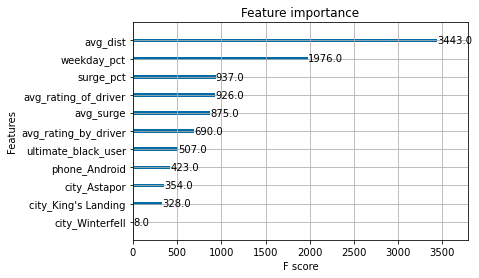

In [116]:
plot_importance(xg_clf_final);

### Conclusions
The default XGBoost model was the best model and resulted in a classification accuracy of 78% for the test data. The factors that impact rider retention the most are the average distance in miles per trip taken and the percent of the user's trips occuring during a weekday. 

For Ultimate to improve its long term rider retention, they can offer a discount for passengers that take a certian number of trips per week or if their average distance exceeds a set treshhold to encourage long term use and retention. 